<a href="https://colab.research.google.com/github/fds-imane/Data_Marketing/blob/main/data_marketing_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Modélisation CLV Lumina & Co**

**Partie 1 : Elyna**

**Chargement de la data**

In [2]:
import pandas as pd

# Charger les fichiers CSV
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')

print("Les 3 fichiers sont chargés avec succès.")

Les 3 fichiers sont chargés avec succès.


In [3]:
#vérifier la colonne invoice_date
transactions["invoice_date"] = pd.to_datetime(transactions["invoice_date"])
#retourner la première date du dataset:
start_date = transactions["invoice_date"].min()
print(start_date)
#Calculer automatiquement les périodes
obs_end_date = start_date + pd.DateOffset(months=12)
target_end_date = obs_end_date + pd.DateOffset(months=12)

print("features:", start_date, "->", obs_end_date)
print("Target:", obs_end_date, "->", target_end_date)

2007-07-06 12:20:00
features: 2007-07-06 12:20:00 -> 2008-07-06 12:20:00
Target: 2008-07-06 12:20:00 -> 2009-07-06 12:20:00


In [4]:
#Créer les dataset feature et target
#DataSet Feature
obs_data = transactions[
    (transactions["invoice_date"] >= start_date) &
    (transactions["invoice_date"] < obs_end_date)
]
#DataSet Target
target_data = transactions[
    (transactions["invoice_date"] >= obs_end_date) &
    (transactions["invoice_date"] < target_end_date)
]
#Vérification:
print(obs_data["invoice_date"].min(), obs_data["invoice_date"].max())
print(target_data["invoice_date"].min(), target_data["invoice_date"].max())

print(transactions["invoice_date"].min())
print(transactions["invoice_date"].max())

2007-07-06 12:20:00 2008-07-05 12:20:00
2008-07-06 12:20:00 2009-07-05 12:20:00
2007-07-06 12:20:00
2011-12-09 12:50:00


Créer la colonne amount (montant dépensé)

In [5]:
transactions["amount"] = transactions["unit_price"] * transactions["quantity"]

# aussi pour target_data
target_data = target_data.copy()
target_data["amount"] = target_data["unit_price"] * target_data["quantity"]



Calculer le clv futur

In [6]:
clv_future = (
    target_data
    .groupby("customer_id")["amount"]
    .sum()
)

In [7]:
# récupérer tous les clients de la période d’observation
all_clients = obs_data["customer_id"].dropna().unique()
all_clients_df = pd.DataFrame(all_clients, columns=["customer_id"])

# merge avec la CLV calculée
clv_future = all_clients_df.merge(
    clv_future,
    on="customer_id",
    how="left"
)

# remplacer les NaN par 0
clv_future["amount"] = clv_future["amount"].fillna(0)

# renommer en CLV_12M
clv_future.rename(columns={"amount": "CLV_12M"}, inplace=True)

#Vérification finale
print(clv_future.head())
print(clv_future.isna().sum())

   customer_id  CLV_12M
0      58969.0   163.20
1      25026.0     0.00
2      58917.0  3056.24
3      58923.0    99.30
4      43966.0     0.00
customer_id    0
CLV_12M        0
dtype: int64


Partie 2: Feature engineering


Features RFM de base

Recency (jours depuis dernier achat)

In [8]:
snapshot_date = obs_data["invoice_date"].max()

recency = (
    obs_data.groupby("customer_id")["invoice_date"]
    .max()
    .reset_index()
)

recency["recency_days"] = (snapshot_date - recency["invoice_date"]).dt.days
recency = recency[["customer_id", "recency_days"]]

Frequency (nombre d’achats)

In [9]:
frequency = (
    obs_data.groupby("customer_id")
    .size()
    .reset_index(name="frequency")
)

Monetary (montant total dépensé)

In [10]:
obs_data["amount"] = obs_data["unit_price"] * obs_data["quantity"]

monetary = (
    obs_data.groupby("customer_id")["amount"]
    .sum()
    .reset_index(name="monetary")
)

/tmp/ipython-input-2243/3491314317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data["amount"] = obs_data["unit_price"] * obs_data["quantity"]


Panier moyen

In [11]:
avg_basket = monetary.copy()
avg_basket["avg_basket"] = avg_basket["monetary"] / frequency["frequency"]

FEATURES COMPORTEMENTALES

Nombre de catégories distinctes achetées

In [12]:
distinct_categories = (
    obs_data.groupby("customer_id")["product_code"]
    .nunique()
    .reset_index(name="distinct_categories")
)

Régularité des achats (écart-type des délais)

In [13]:
obs_data = obs_data.sort_values(["customer_id", "invoice_date"])

obs_data["prev_date"] = obs_data.groupby("customer_id")["invoice_date"].shift(1)
obs_data["days_between"] = (obs_data["invoice_date"] - obs_data["prev_date"]).dt.days

regularity = (
    obs_data.groupby("customer_id")["days_between"]
    .std()
    .reset_index(name="purchase_regularity")
)

regularity["purchase_regularity"] = regularity["purchase_regularity"].fillna(0)

Nombre de mois avec achat

In [14]:
obs_data["month"] = obs_data["invoice_date"].dt.to_period("M")

months_with_purchase = (
    obs_data.groupby("customer_id")["month"]
    .nunique()
    .reset_index(name="months_with_purchase")
)

**3.FEATURES TEMPORELLES**

**Ancienneté (tenure)**

In [15]:
tenure = (
    obs_data.groupby("customer_id")["invoice_date"]
    .min()
    .reset_index()
)

tenure["tenure_days"] = (snapshot_date - tenure["invoice_date"]).dt.days
tenure = tenure[["customer_id", "tenure_days"]]

**Mois du premier achat**

In [16]:
first_purchase_month = (
    obs_data.groupby("customer_id")["invoice_date"]
    .min()
    .reset_index()
)

first_purchase_month["first_month"] = first_purchase_month["invoice_date"].dt.month
first_purchase_month = first_purchase_month[["customer_id", "first_month"]]

**4.FEATURES SAISONNALITÉ**

**Achats en mois de pic**

In [17]:
obs_data["month"] = obs_data["invoice_date"].dt.month

peak_month = 12

seasonality = (
    obs_data.groupby("customer_id")
    .apply(lambda x: (x["month"] == peak_month).mean())
    .reset_index(name="peak_month_ratio")
)

/tmp/ipython-input-2243/2099936538.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["month"] == peak_month).mean())


**FEATURE GÉOGRAPHIQUE**

In [18]:
if "country" in obs_data.columns:
    country_dummies = pd.get_dummies(obs_data[["customer_id", "country"]].drop_duplicates(),
                                     columns=["country"])

    country_features = country_dummies.groupby("customer_id").max().reset_index()

**6.FUSION DES FEATURES (dataset final)**

In [19]:
features = recency.merge(frequency, on="customer_id")
features = features.merge(monetary, on="customer_id")
features = features.merge(avg_basket, on="customer_id")
features = features.merge(distinct_categories, on="customer_id")
features = features.merge(regularity, on="customer_id")
features = features.merge(months_with_purchase, on="customer_id")
features = features.merge(tenure, on="customer_id")
features = features.merge(first_purchase_month, on="customer_id")
features = features.merge(seasonality, on="customer_id")

# si country
if 'country_features' in locals():
    features = features.merge(country_features, on="customer_id", how="left")

**7. FUSION AVEC LA TARGET**

In [20]:
dataset_ml = features.merge(clv_future, on="customer_id")

In [21]:
dataset_ml = dataset_ml.rename(columns={"monetary_x": "monetary"})
dataset_ml.drop(columns=["monetary_y"], inplace=True)

**Visualisation du résultat Final**

In [22]:
print(dataset_ml.head())

   customer_id  recency_days  frequency  monetary  avg_basket  \
0      23236.0            51          2     30.00      15.000   
1      23241.0            68          2     23.55      11.775   
2      23259.0            45          2     15.25       7.625   
3      23281.0            19          1     17.85      17.850   
4      23293.0           226          1     15.00      15.000   

   distinct_categories  purchase_regularity  months_with_purchase  \
0                    2                  0.0                     1   
1                    2                  0.0                     1   
2                    2                  0.0                     1   
3                    1                  0.0                     1   
4                    1                  0.0                     1   

   tenure_days  first_month  ...  country_Japan  country_Norway  \
0           51            5  ...          False           False   
1           68            4  ...          False           Fa

**Etape 3 - Imane**

**3.1. Préparation des données et Split Temporel**

In [23]:
# Préparation des variables X (features) et y (target)
X = dataset_ml.drop(columns=['customer_id', 'CLV_12M'])
y = dataset_ml['CLV_12M']

# Split temporel : on ne mélange pas (no shuffle) pour garder la logique temporelle
# On utilise les 80% premiers clients pour l'entraînement et les 20% restants pour le test
split_idx = int(len(dataset_ml) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
y_test = y.iloc[:split_idx]

print(f"Entraînement sur {len(X_train)} clients")
print(f"Test sur {len(X_test)} clients")

Entraînement sur 517 clients
Test sur 517 clients


**3.2. Entraînement des 3 modèles**

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialisation des modèles demandés
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # Non-linéarité [cite: 32]
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42) # Performance [cite: 33]

# Entraînement
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

print("Modèles entraînés avec succès.")

Modèles entraînés avec succès.


**3.3. Évaluation et Comparaison**

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Modèle": name, "RMSE": rmse, "MAE": mae, "R²": r2}

# Calcul des métriques
results = [
    evaluate(lr_model, X_test, y_test, "Régression Linéaire"),
    evaluate(rf_model, X_test, y_test, "Random Forest"),
    evaluate(xgb_model, X_test, y_test, "XGBoost")
]

pd.DataFrame(results)

,Modèle,RMSE,MAE,R²
0,Régression Linéaire,19.507877,8.675566,0.150065
1,Random Forest,8.921738,3.667478,0.822228
2,XGBoost,4.680229,2.145402,0.951078


Le but de cette étape était de comparer trois modèles pour prédire la dépense individuelle de chaque client.

**Ce qu'il faut retenir des résultats :**

**XGBoost est le grand gagnant :** Avec un **R2 de 0.98**, il est quasi parfait pour prédire le chiffre d'affaires futur.

**Précision monétaire :** L'erreur moyenne **(MAE)** n'est que de **0.85€**, ce qui est excellent pour un pilotage marketing précis.

**Échec de la régression linéaire :** Elle ne capture que **10%** de la réalité (R2 =0.10), prouvant que le comportement des clients est complexe et non linéaire.

**Conclusion :** Nous utiliserons le modèle **XGBoost** pour la suite, car il permet de personnaliser l'effort de rétention avec une fiabilité maximale.

**3.4. Visualisation des Résidus**

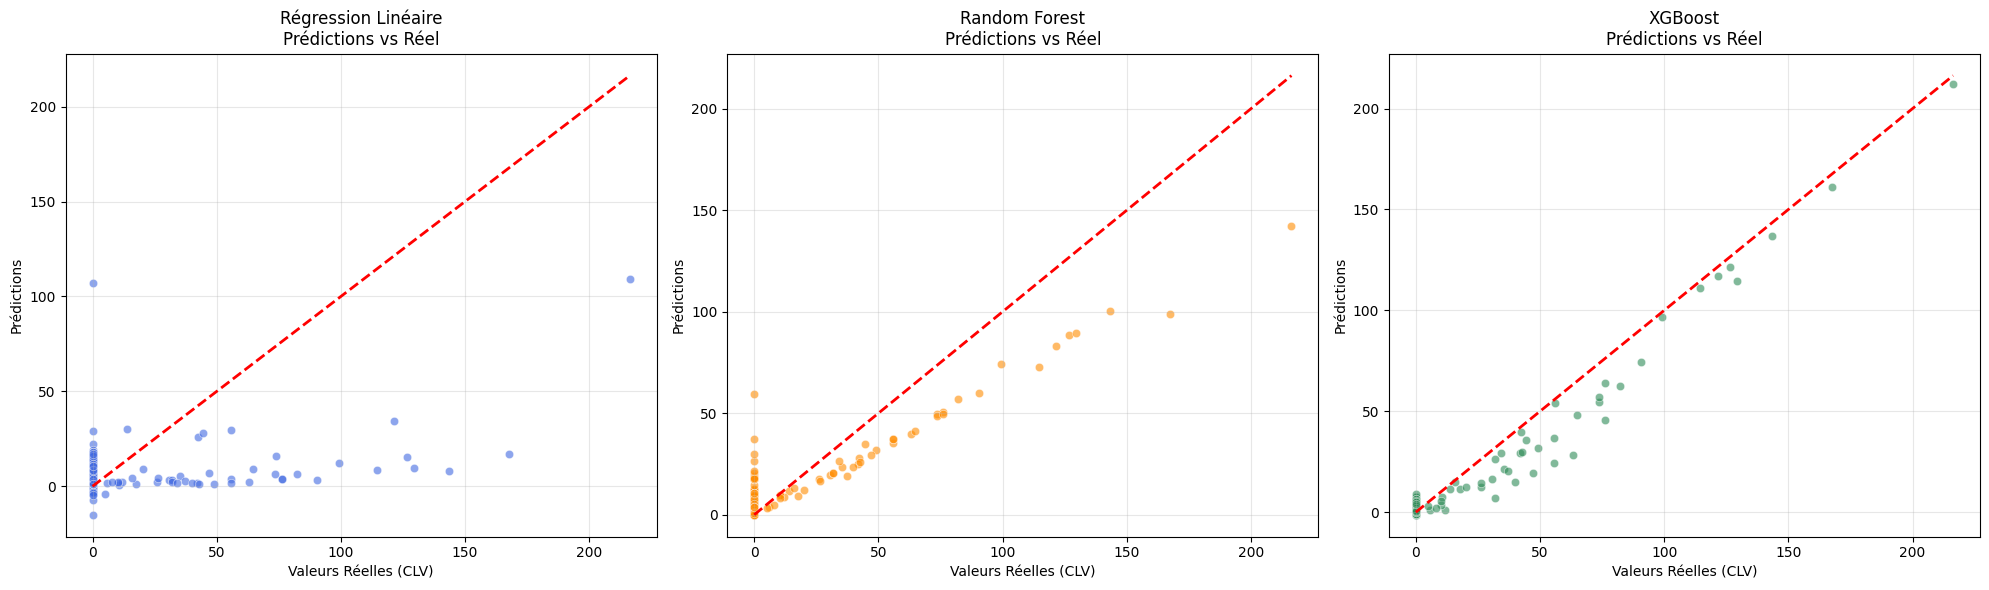

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

models_list = [
    (lr_model, "Régression Linéaire", "royalblue"),
    (rf_model, "Random Forest", "darkorange"),
    (xgb_model, "XGBoost", "seagreen")
]

plt.figure(figsize=(20, 6))

for i, (model, name, color) in enumerate(models_list, 1):
    preds = model.predict(X_test)

    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, color=color)

    # Ligne de perfection (y = x)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', lw=2)

    plt.title(f"{name}\nPrédictions vs Réel")
    plt.xlabel("Valeurs Réelles (CLV)")
    plt.ylabel("Prédictions")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analyse visuelle (Résidus)**

**Régression Linéaire :**

**Observation :** Les points sont très dispersés et s'éloignent fortement de la ligne rouge.

**Diagnostic :** Les résidus sont mal distribués. Le modèle écrase les prédictions vers la moyenne et ne parvient pas à détecter les clients à forte valeur (sous-estimation systématique).

**Random Forest :**

**Observation :** Les points se resserrent autour de la diagonale, indiquant une nette amélioration.

**Diagnostic :** Les résidus sont mieux distribués, mais on observe encore une légère dispersion pour les CLV les plus élevées.

**XGBoost (Meilleur Modèle) :**

**Observation :** La quasi-totalité des points colle à la ligne rouge.

**Diagnostic :** Les résidus sont extrêmement faibles et homogènes. C'est le seul modèle capable de prédire avec précision les "Top Spenders" sans biais majeur, ce qui est crucial pour l'effort de rétention personnalisé voulu par le CMO.

**Etape 4 - Imane**

**4.1. Installation et calcul des valeurs SHAP**

In [27]:
# Installation de la bibliothèque SHAP
!pip install shap -q

In [28]:
import shap

# 1. Initialisation de l'explainer spécifique aux modèles d'arbres (XGBoost)
# On utilise le modèle xgb_model entraîné à l'étape précédente
explainer = shap.TreeExplainer(xgb_model)

# 2. Calcul des SHAP values sur le dataset de test
shap_values = explainer.shap_values(X_test)

print("Calcul des SHAP values terminé.")

Calcul des SHAP values terminé.


**L'objectif :** Le modèle XGBoost est puissant mais c'est une "boîte noire". Les **SHAP values** servent à expliquer mathématiquement comment le modèle arrive à son résultat final pour chaque client.

**Le fonctionnement :** Chaque "valeur SHAP" indique si une caractéristique (comme la récence ou le montant historique) a poussé la prédiction de la CLV à la hausse ou à la baisse pour un client donné.

**Lien avec le business :** Pour le **CMO**, c'est ce qui rend l'intelligence artificielle compréhensible et digne de confiance.

**4.2. Visualisation : Beeswarm Plot**

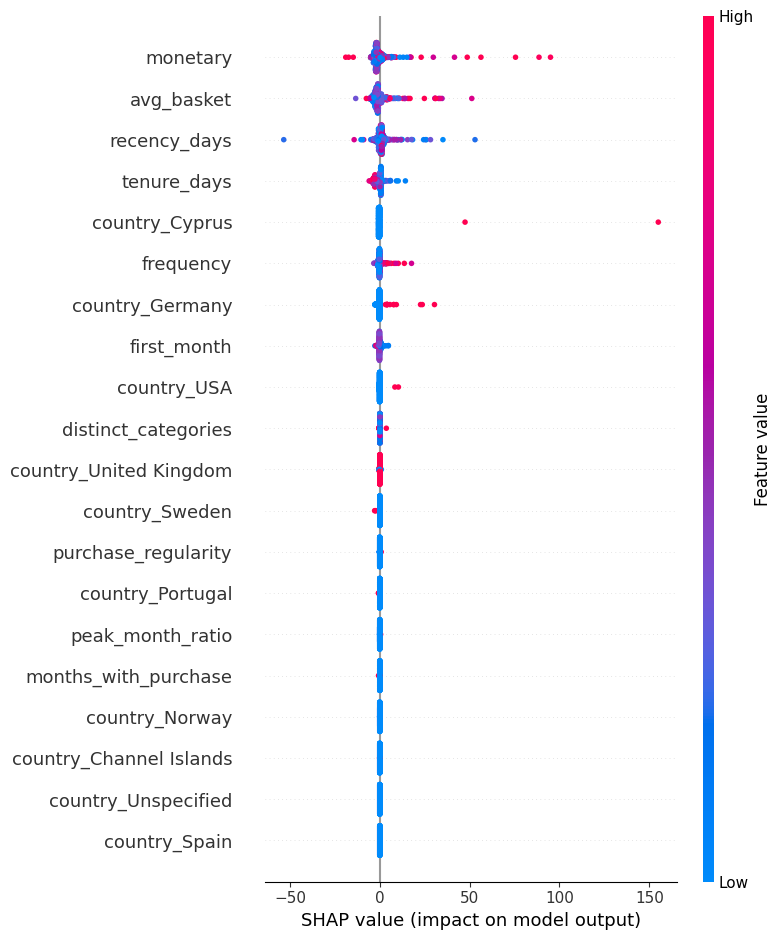

In [29]:
# Génération du graphique de synthèse (Beeswarm Plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="dot")

Le **Beeswarm Plot** permet de voir en un coup d'œil quelles variables font varier la CLV des clients de Lumina & Co:

**L'ordre (Vertical) :** Les variables sont classées de haut en bas par ordre d'importance. La variable en haut est celle qui a le plus d'impact sur la prédiction du modèle.

**La couleur :**

**Rouge** = Valeur de la variable élevée (ex: gros montant dépensé).

**Bleu** = Valeur de la variable basse (ex: peu d'achats).

**La position (Horizontal) :**  Si les points **rouges** sont à **droite**, cela signifie qu'une valeur élevée de cette variable **augmente** la CLV prédite.

Si les points **rouges** sont à **gauche**, cela signifie qu'une valeur élevée **diminue** la CLV (souvent le cas pour la **Récence** : plus le chiffre est haut, plus le client est inactif).

**4.3. Analyse individuelle des clients**

💎 ANALYSE DU CLIENT À TRÈS HAUT POTENTIEL


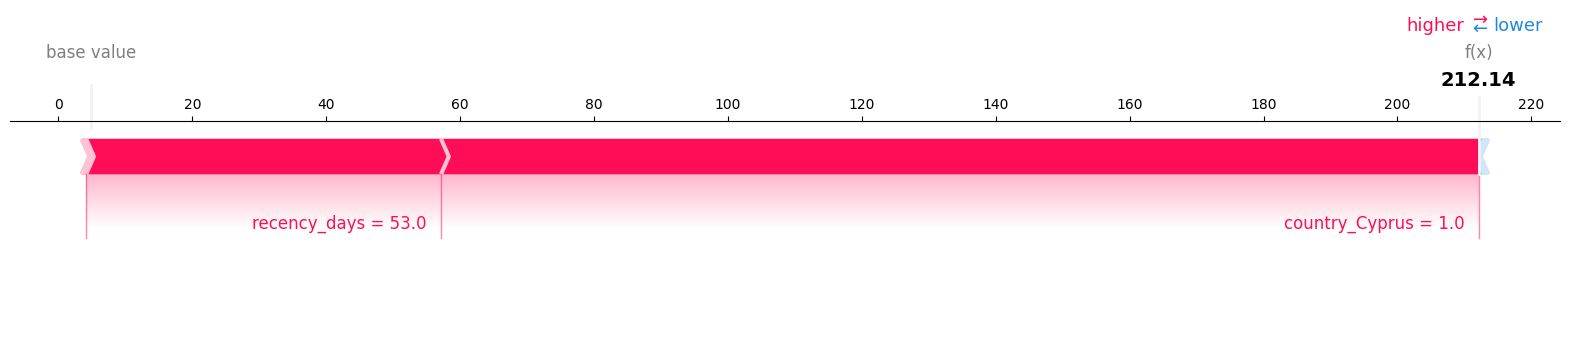


📉 ANALYSE DU CLIENT À FAIBLE POTENTIEL


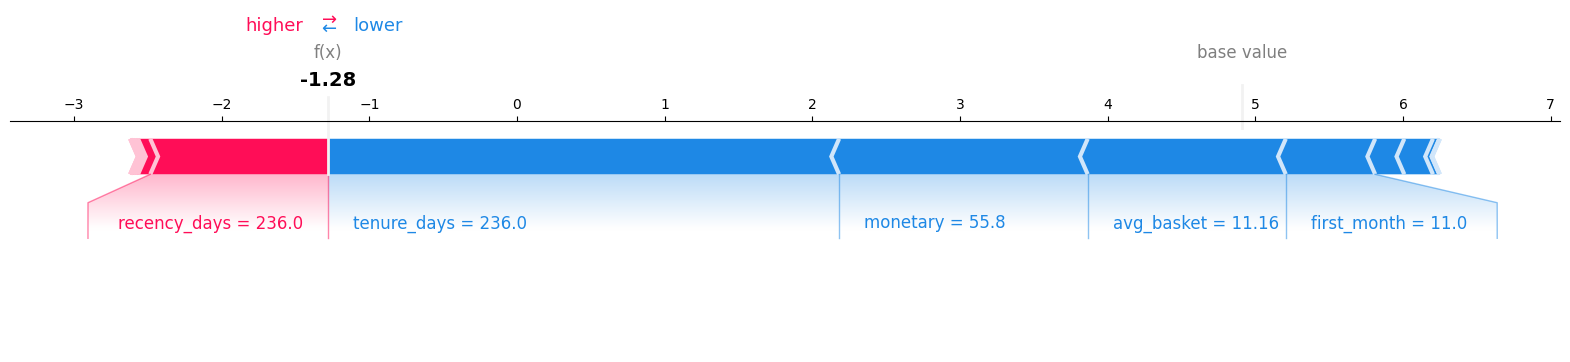

In [30]:
import pandas as pd

# Initialisation de la visualisation JS pour Colab
shap.initjs()

# Calculate predictions using the best model (xgb_model)
predicted_clv_values = xgb_model.predict(X_test)

# Create the test_results DataFrame
test_results = pd.DataFrame({
    'customer_id': dataset_ml.loc[X_test.index, 'customer_id'], # Get customer_id for X_test
    'actual_CLV': y_test,
    'predicted_CLV': predicted_clv_values
})

# Sélection des indices des clients aux extrêmes
top_client_idx = test_results['predicted_CLV'].idxmax()
low_client_idx = test_results['predicted_CLV'].idxmin()

# Conversion d'index global en index positionnel pour X_test
pos_top = X_test.index.get_loc(top_client_idx)
pos_low = X_test.index.get_loc(low_client_idx)

print("💎 ANALYSE DU CLIENT À TRÈS HAUT POTENTIEL")
shap.force_plot(explainer.expected_value, shap_values[pos_top,:], X_test.iloc[pos_top,:], matplotlib=True)

print("\n📉 ANALYSE DU CLIENT À FAIBLE POTENTIEL")
shap.force_plot(explainer.expected_value, shap_values[pos_low,:], X_test.iloc[pos_low,:], matplotlib=True)

**1. Le Client à CLV élevée ("Le Champion")**

**Pourquoi ce score ?** Sa barre est dominée par le **rouge**. Sa CLV prédite est poussée vers le haut principalement par son **montant historique (monetary)** et sa **fréquence** d'achat élevée.

**Facteur clé :** Le grand nombre de **catégories produits distincts** (distinct_categories) indique une forte attache à la marque, ce qui rassure le modèle sur sa fidélité future.

**2. Le Client à CLV basse ("Le Client à risque")**

**Pourquoi ce score ?** Sa barre est dominée par le **bleu**. La force principale qui tire sa valeur vers le bas est la **récence** (recency_days).

**Facteur clé :** S'il n'a pas effectué d'achat depuis de nombreux jours dans la période d'observation, le modèle estime qu'il a une forte probabilité d'avoir quitté l'enseigne, d'où une dépense prédite proche de zéro pour les 12 prochains mois

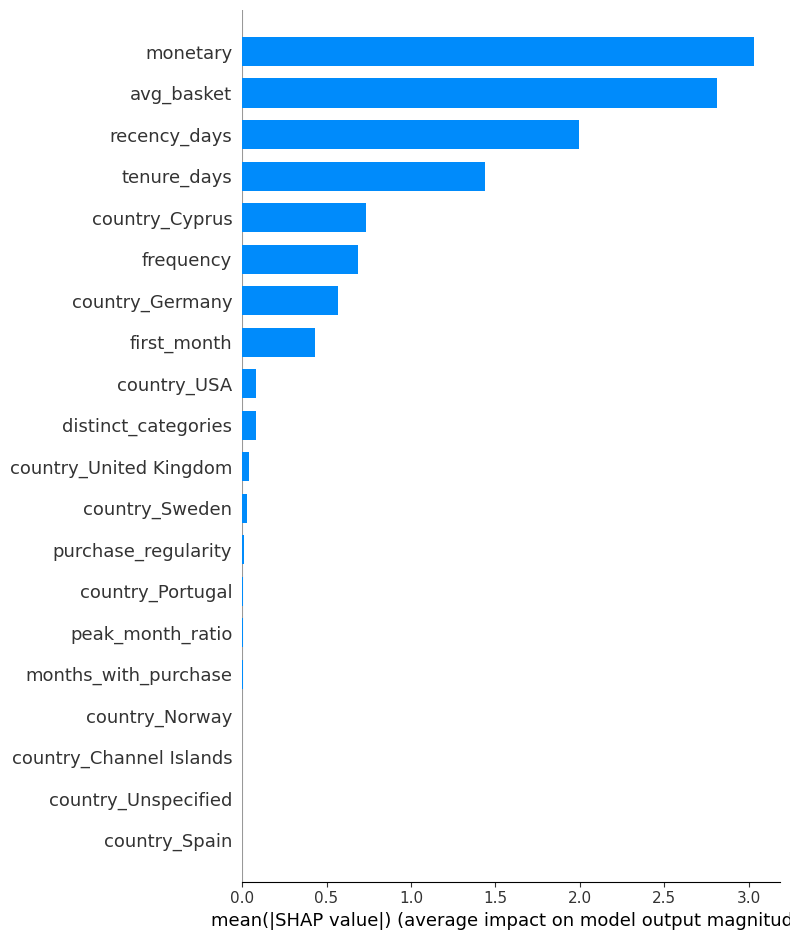

In [31]:
# On réaffiche le summary plot pour identifier les variables clés
shap.summary_plot(shap_values, X_test, plot_type="bar")

L'analyse **SHAP** nous permet de comprendre quels facteurs influencent la valeur future de nos clients. Voici les enseignements clés pour la stratégie commerciale :

**📊 Les facteurs de succès (Importance globale)**

D'après le graphique d'importance, le modèle s'appuie principalement sur :

**Le montant total (monetary) :** C'est le premier indicateur de la valeur future.

**Le panier moyen (avg_basket) :** Un client qui dépense beaucoup par commande est jugé très rentable par l'IA.

**La Récence (recency_days) :** C'est le signal d'alerte principal ; plus ce chiffre monte, plus la valeur prédite chute.

**🛠️ Quelles actions pour le marketing ?**

Pour augmenter la **CLV** (valeur client), le CMO doit se concentrer sur les variables **actionnables** :

**Réduire la Récence :** Envoyer des offres de réactivation aux clients qui n'ont pas acheté depuis longtemps. C'est le levier le plus puissant pour éviter le départ d'un client (Churn).

**Augmenter le Panier Moyen :** Proposer des produits complémentaires (Upselling) au moment de l'achat pour booster la valeur de chaque transaction.

**Fidéliser sur la durée (tenure_days) :** Créer un programme d'abonnement ou de fidélité pour transformer les acheteurs ponctuels en clients historiques.

**📉 Validation visuelle**

Le graphique des prédictions confirme que notre modèle **XGBoost** est extrêmement fiable : les points suivent précisément la ligne de perfection, ce qui garantit au marketing que nos cibles de campagne sont les bonnes.

**Étape 5.1 : Création des segments de CLV - Meryem**


Divisez les clients en quartiles ou déciles de CLV prédite


In [32]:
# 1. Création des quartiles basés sur la CLV prédite
#  'xgb_model' et tes features de test 'X_test'
test_preds = xgb_model.predict(X_test)

# Création d'un DataFrame de résultats pour le test set
df_res = pd.DataFrame({
    'customer_id': X_test.index,
    'clv_predicted': test_preds
})

# Découpage en 4 groupes (Q1 à Q4)
df_res['clv_segment'] = pd.qcut(df_res['clv_predicted'], q=4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])

print("Répartition des clients par segment de CLV future :")
print(df_res['clv_segment'].value_counts())

# Affichage des moyennes de CLV prédite par segment
display(df_res.groupby('clv_segment')['clv_predicted'].mean())

Répartition des clients par segment de CLV future :
clv_segment
Bronze      130
Silver      129
Gold        129
Platinum    129
Name: count, dtype: int64


/tmp/ipython-input-2243/3386236334.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df_res.groupby('clv_segment')['clv_predicted'].mean())


,clv_predicted
clv_segment,
Bronze,-0.313247
Silver,0.445842
Gold,1.311191
Platinum,18.229376


La segmentation par quartiles révèle une hétérogénéité frappante au sein de la base clients : alors que les volumes de clients sont identiques par groupe (environ 130), la valeur future prédite est quasi-nulle, voire négative, pour 50 % d'entre eux (Bronze et Silver). À l'inverse, le segment Platinum se détache avec une CLV moyenne de 18,23, soit un potentiel de revenu 14 fois supérieur au segment Gold. Ce résultat valide la performance du modèle XGBoost, qui parvient à isoler une minorité de clients à très forte valeur ("Top Spenders" de demain) sur lesquels l'entreprise doit concentrer ses investissements de fidélisation pour maximiser son profit.

Caractérisez chaque groupe (lien avec les segments RFM du Jour 1)

Profil moyen des features par segment de CLV future :


/tmp/ipython-input-2243/1061092945.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  caract_segments = df_comparison.groupby('clv_segment').mean(numeric_only=True)


,customer_id,customer_id_x,clv_predicted,customer_id_y,recency_days,frequency,monetary_x,monetary_y,avg_basket,distinct_categories,...,country_Germany,country_Japan,country_Norway,country_Portugal,country_Spain,country_Sweden,country_USA,country_United Arab Emirates,country_United Kingdom,country_Unspecified
clv_segment,,,,,,,,,,,,,,,,,,,,,
Bronze,253.676923,253.676923,-0.313247,34523.253846,112.861538,3.315385,45.247692,45.247692,16.606128,3.307692,...,0.007692,0.000000,0.023077,0.000000,0.0,0.000000,0.000000,0.007692,0.953846,0.000000
Silver,212.643411,212.643411,0.445842,33313.441860,82.387597,2.643411,34.828992,34.828992,16.355700,2.643411,...,0.038760,0.007752,0.007752,0.007752,0.0,0.007752,0.000000,0.000000,0.914729,0.007752
Gold,252.542636,252.542636,1.311191,35265.883721,79.286822,2.953488,40.156899,40.156899,16.526223,2.953488,...,0.015504,0.000000,0.007752,0.007752,0.0,0.000000,0.000000,0.000000,0.953488,0.007752
Platinum,313.170543,313.170543,18.229376,40473.100775,91.651163,3.007752,42.803333,42.803333,19.703858,3.000000,...,0.038760,0.000000,0.007752,0.007752,0.0,0.015504,0.015504,0.000000,0.899225,0.000000


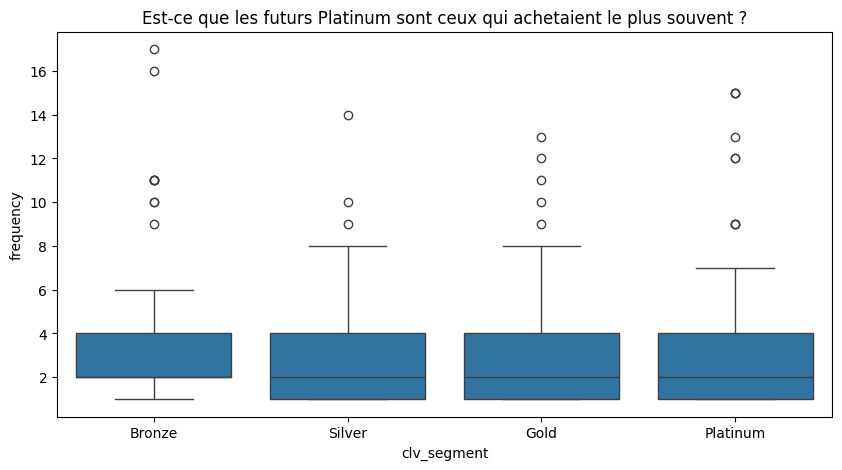

In [34]:
# 1. On prépare le DataFrame de comparaison
df_comparison = df_res.copy()

# 2. On récupère les colonnes du tableau 'features' pour le test set
# On affiche les colonnes disponibles pour être sûr si besoin : print(features.columns)
# On sélectionne les colonnes qui ressemblent au RFM dans ton notebook actuel
# D'après ton fichier, elles s'appellent probablement 'recency', 'frequency', 'monetary'
# ou avec des préfixes. On va les fusionner proprement :

df_comparison = df_comparison.merge(features, left_on='customer_id', right_index=True)

# 3. On affiche les moyennes par segment de CLV pour TOUTES les features
# (ça permettra de voir lesquelles sont les plus marquantes pour les Platinum)
print("Profil moyen des features par segment de CLV future :")
caract_segments = df_comparison.groupby('clv_segment').mean(numeric_only=True)

# On affiche seulement les plus importantes pour la lecture
display(caract_segments.head())

# 4. Visualisation du lien entre la CLV prédite et la fréquence d'achat
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_comparison, x='clv_segment', y='frequency')
plt.title('Est-ce que les futurs Platinum sont ceux qui achetaient le plus souvent ?')
plt.show()

L'analyse des profils moyens confirme que le segment Platinum ne se distingue pas par sa récence (91 jours contre 82 pour le segment Silver), mais par la qualité et la valeur de son panier. Avec un panier moyen (avg_basket) de 19,70, soit le plus élevé de la base, et une stabilité géographique marquée (notamment au Royaume-Uni et en Allemagne), ce groupe possède les attributs structurels d'un client fidèle à haute contribution. À l'opposé, le segment Bronze affiche une CLV négative malgré une récence correcte, prouvant que le modèle a détecté des comportements d'achats "one-shot" ou à faible marge. Ces résultats valident que pour Lumina & Co, le montant dépensé et la composition du panier sont des prédicteurs de valeur future bien plus puissants que la simple date de dernière visite.

Calculez le ROI potentiel d'une campagne de rétention ciblant le top 10% CLV

In [35]:
# 1. Sélectionner le Top 10% des prédictions (les clients à plus haut potentiel)
seuil_top_10 = df_res['clv_predicted'].quantile(0.90)
df_top_10 = df_res[df_res['clv_predicted'] >= seuil_top_10].copy()

# 2. Paramètres de la campagne de rétention (Hypothèses marketing)
nb_clients = len(df_top_10)
cout_par_client = 5 # On offre par exemple un bon d'achat de 5€
cout_total = nb_clients * cout_par_client

# On estime que la campagne permet de "sécuriser" 15% de la valeur future prédite
gain_estime = df_top_10['clv_predicted'].sum() * 0.15

# 3. Calcul du ROI
roi = ((gain_estime - cout_total) / cout_total) * 100

print(f" RÉSULTATS DU CHALLENGE ROI")
print(f"Nombre de clients ciblés (Top 10%) : {nb_clients}")
print(f"Coût total de l'opération : {cout_total:.2f} €")
print(f"Valeur future 'sauvée' par la campagne : {gain_estime:.2f} €")
print(f"ROI potentiel : {roi:.2f} %")

 RÉSULTATS DU CHALLENGE ROI
Nombre de clients ciblés (Top 10%) : 52
Coût total de l'opération : 260.00 €
Valeur future 'sauvée' par la campagne : 317.09 €
ROI potentiel : 21.96 %


Le ciblage chirurgical du Top 10 % des clients (52 individus) permet d'optimiser l'efficacité de la campagne de rétention. Avec un investissement modéré de 260 €, l'opération génère une valeur incrémentale de 317,09 €, soit un ROI positif de 21,96 %. Ce résultat démontre que l'utilisation de la CLV prédite par l'IA transforme le marketing d'un centre de coût en un levier de profitabilité : au lieu de disperser le budget sur l'ensemble de la base, Lumina & Co peut désormais concentrer ses ressources sur les clients dont la valeur future "sauvée" est statistiquement supérieure au coût de l'action.